In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import os
import time
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from JEMPP.Task.acc import test_clf

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
args = argparse.Namespace()
args.batch_size = 64
args.buffer_size = 10000
args.class_cond_p_x_sample = False
args.clf_only = False
args.data_root = "../data"
args.dataset = "cifar10"
args.debug = True
args.decay_epochs = [35, 80, 120]
args.decay_rate = 0.1
args.decay_step = True
args.depth = 28
args.dir_path = "./runs/YOPO-debug/cifar10/notebook_debug1"
args.dropout_rate = 0.0
args.eps = 1.0
args.eval_every = 1
args.exp_marker = "method-eps=1.0-in_lr=0.02-n_steps=10-in_steps=10"
args.exp_name = "YOPO"
args.gpu_id = "4"
args.hostname = "nitro2"
args.in_lr = 0.02
args.in_steps = 10
args.labels_per_class = -1
args.load_path = None
args.log_arg = "method-eps-in_lr-n_steps-in_steps"
args.log_dir = "./runs"
args.lr = 0.1
args.model = "wrn"
args.n_classes = 10
args.n_epochs = 150
args.n_steps = 0
args.n_valid = 5000
args.mcmc_num_steps = 30
args.mcmc_step_size_b_square = 2e-4
args.norm = 'batch'
args.note = "reinit_noise"
args.optimizer = "adam"
args.p_x_weight = 1.0
args.p_x_y_weight = 0.0
args.p_y_given_x_weight = 1.0
args.pid = 118423
args.print_every = 100
args.print_to_log = False
args.reinit_freq = 0.05
args.save_dir = "./runs/YOPO-debug/cifar10/notebook_debug1"
args.sgld_lr = 1.0
args.sgld_std = 0.01
args.sigma = 0.03
args.start_sgld = 100
args.vis = False
args.warmup_iters = 1000
args.weight_decay = 0.0
args.width = 10
args.seed = 1

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
args.device = device

args.img_sz = 32
args.num_diffusion_timesteps = 6
args.opt = 'sgd'
args.ma_decay = 0.999
args.resume = None

In [5]:
from utils import get_data

load_train, load_train_labeled, load_valid, load_test = get_data(args)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
from models.jem_models import CCF
model_cls = CCF
f = model_cls(args.depth, args.width, args.norm, n_classes=args.n_classes, model=args.model)

| Wide-Resnet 28x10


In [4]:
def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1  # and timesteps.dtype == torch.int32

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(0, half_dim) * -emb)
    emb = torch.matmul(timesteps.reshape(-1, 1), emb.reshape(1, -1))
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        # emb = torch.cat([emb, torch.zeros([num_embeddings, 1])], axis=1)
        emb = F.pad(emb, (0, 1, 0, 0))
    assert emb.shape == [timesteps.shape[0], embedding_dim]
    return emb


def get_sigma_schedule(beta_start, beta_end, num_diff_steps):
    betas = np.linspace(beta_start, beta_end, 1000, dtype=np.float64)
    betas = np.append(betas, 1.)
    assert isinstance(betas, np.ndarray)
    betas = betas.astype(np.float64)
    assert (betas > 0).all() and (betas <= 1).all()
    sqrt_alphas = np.sqrt(1. - betas)
    idx = torch.cast(np.concatenate([np.arange(num_diff_steps) * (1000 // ((num_diff_steps - 1) * 2)), [999]]), dtype=torch.int32)
    a_s = np.concatenate([[np.prod(sqrt_alphas[: idx[0] + 1])], np.asarray([np.prod(sqrt_alphas[idx[i - 1] + 1: idx[i] + 1]) for i in np.arange(1, len(idx))])])
    sigmas = np.sqrt(1 - a_s ** 2)

    return sigmas, a_s

In [8]:
# I just remove redundant code,  so ~~~
from models import resnet50

In [9]:
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s: %(filename)s[%(lineno)d]: %(message)s", datefmt="%m-%d %H:%M:%S")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [6]:
def get_beta_schedule(*, beta_start, beta_end, num_diffusion_timesteps):
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    betas = np.append(betas, 1.)
    assert betas.shape == (num_diffusion_timesteps + 1,)


    return betas


def get_sigma_schedule(*, beta_start, beta_end, num_diffusion_timesteps):
    """
    Get the noise level schedule
    :param beta_start: begin noise level
    :param beta_end: end noise level
    :param num_diffusion_timesteps: number of timesteps
    :return:
    -- sigmas: sigma_{t+1}, scaling parameter of epsilon_{t+1}
    -- a_s: sqrt(1 - sigma_{t+1}^2), scaling parameter of x_t
    """
    betas = np.linspace(beta_start, beta_end, 1000, dtype=np.float64)
    betas = np.append(betas, 1.)
    assert isinstance(betas, np.ndarray)
    betas = betas.astype(np.float64)
    assert (betas > 0).all() and (betas <= 1).all()
    sqrt_alphas = np.sqrt(1. - betas)
    temp = np.concatenate([np.arange(num_diffusion_timesteps) * (1000 // ((num_diffusion_timesteps - 1) * 2)), [999]])
    idx = temp.astype(np.int32)
    a_s = np.concatenate(
        [[np.prod(sqrt_alphas[: idx[0] + 1])],
         np.asarray([np.prod(sqrt_alphas[idx[i - 1] + 1: idx[i] + 1]) for i in np.arange(1, len(idx))])])
    sigma = np.sqrt(1 - a_s ** 2)

    return sigma, a_s

sigmas, a_s = get_sigma_schedule(beta_start=0.0001, beta_end=0.02, num_diffusion_timesteps=6)
print(sigmas.shape)
print(a_s.shape)
print(a_s, sigmas)

(7,)
(7,)
[0.99995    0.94616654 0.85629003 0.77479621 0.70091772 0.63395611
 0.02277645] [0.01       0.32368022 0.51649529 0.63221107 0.71324214 0.77336903
 0.99974058]


In [11]:

class RecoveryLikelihood(nn.Module):
    def __init__(self, args):
        super(RecoveryLikelihood, self).__init__()
        self.args = args
        self.num_timesteps = args.num_diffusion_timesteps

        sigmas, a_s = get_sigma_schedule(beta_start=0.0001, beta_end=0.02, num_diffusion_timesteps=self.num_timesteps)
        self.sigmas = torch.FloatTensor(sigmas).to(args.device)
        self.a_s = torch.FloatTensor(a_s).to(args.device)

        self.a_s_cum = torch.FloatTensor(np.cumprod(a_s)).to(args.device)
        self.sigmas_cum = torch.sqrt(1 - self.a_s_cum ** 2)
        self.a_s_prev = self.a_s.clone()
        self.a_s_prev[-1] = 1
        self.is_recovery = torch.ones(self.num_timesteps + 1)
        self.is_recovery[-1] = 0
        self.device = args.device

        # self.net = net_res_temb2(name='net', ch=128, ch_mult=ch_mult, num_res_blocks=self.args.num_res_blocks, attn_resolutions=(16,))
        self.net = resnet50().to(args.device)

    @staticmethod
    def _extract(a, t, x_shape, device):
        """
        Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
        """
        if isinstance(t, int) or len(t.shape) == 0:
            t = torch.ones(x_shape[0], dtype=torch.int64, device=device) * t
        bs, = t.shape
        assert x_shape[0] == bs
        out = a[t]
        # out = tf.gather(tf.convert_to_tensor(a, dtype=tf.float32), t)
        # print(out.shape, t.shape, bs)
        assert list(out.shape) == [bs]
        return torch.reshape(out, [bs] + ((len(x_shape) - 1) * [1]))

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data (t == 0 means diffused for 1 step)
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        assert noise.shape == x_start.shape
        x_t = self._extract(self.a_s_cum, t, x_start.shape, self.args.device) * x_start + \
              self._extract(self.sigmas_cum, t, x_start.shape, self.args.device) * noise

        return x_t

    def q_sample_pairs(self, x_start, t):
        """
        Generate a pair of disturbed images for training
        :param x_start: x_0
        :param t: time step t
        :return: x_t, x_{t+1}
        """
        noise = torch.randn_like(x_start)
        x_t = self.q_sample(x_start, t)
        x_t_plus_one = self._extract(self.a_s, t+1, x_start.shape, self.args.device) * x_t + \
                       self._extract(self.sigmas, t+1, x_start.shape, self.args.device) * noise

        return x_t, x_t_plus_one

    def q_sample_progressive(self, x_0):
        """
        Generate a full sequence of disturbed images
        """
        x_preds = []
        for t in range(self.num_timesteps + 1):
            t_now = torch.ones([x_0.shape[0]], dtype=torch.int32, device=self.args.device) * t
            x = self.q_sample(x_0, t_now)
            x_preds.append(x)
        x_preds = torch.stack(x_preds, axis=0)

        return x_preds

    # === Training loss ===
    def training_losses(self, x_pos, x_neg, t):
        """
        Training loss calculation
        """
        a_s = self._extract(self.a_s_prev, t + 1, x_pos.shape, self.args.device)
        y_pos = a_s * x_pos
        y_neg = a_s * x_neg
        pos_f = self.net(y_pos, t).sum(dim=1)
        neg_f = self.net(y_neg, t).sum(dim=1)
        loss = - (pos_f - neg_f)

        loss_scale = 1.0 / (self.sigmas[t + 1] / self.sigmas[1])
        loss = loss_scale * loss

        loss_ts = torch.math.unsorted_segment_mean(torch.abs(loss), t, self.num_timesteps)
        f_ts = torch.math.unsorted_segment_mean(torch.abs(pos_f), t, self.num_timesteps)

        return loss.mean(), loss_ts, f_ts

    def log_prob(self, y, t, tilde_x, b0, sigma, is_recovery):
        logits = self.net(y, t)

        return logits.sum(dim=1) / torch.reshape(b0, [-1]) - torch.sum((y - tilde_x) ** 2 / 2 / sigma ** 2 * is_recovery, dim=[1, 2, 3])

    def grad_f(self, y, t, tilde_x, b0, sigma, is_recovery):
        log_p_y = self.log_prob(y, t, tilde_x, b0, sigma, is_recovery)
        grad_y = torch.autograd.grad(log_p_y, [y], retain_graph=True)[0]
        return grad_y, log_p_y

    # === Sampling ===
    def p_sample_langevin(self, tilde_x, t):
        """
        Langevin sampling function
        """
        sigma = self._extract(self.sigmas, t + 1, tilde_x.shape, self.args.device)
        sigma_cum = self._extract(self.sigmas_cum, t, tilde_x.shape, self.args.device)
        is_recovery = self._extract(self.is_recovery, t + 1, tilde_x.shape, self.args.device)
        a_s = self._extract(self.a_s_prev, t + 1, tilde_x.shape, self.args.device)

        c_t_square = sigma_cum / self.sigmas_cum[0]
        step_size_square = c_t_square * self.args.mcmc_step_size_b_square * sigma ** 2

        # y = torch.identity(tilde_x)
        y = torch.autograd.Variable(tilde_x, requires_grad=True)
        is_accepted_summary = torch.zeros(y.shape[0], dtype=torch.float32)

        grad_y, log_p_y = self.grad_f(y, t, tilde_x, step_size_square, sigma, is_recovery)

        for _ in range(self.args.mcmc_num_steps):
            noise = torch.randn(y.shape)
            y_new = y + 0.5 * step_size_square * grad_y + torch.sqrt(step_size_square) * noise * self.args.noise_scale

            grad_y_new, log_p_y_new = self.grad_f(y_new, t, tilde_x, step_size_square, sigma, is_recovery)
            y, grad_y, log_p_y = y_new, grad_y_new, log_p_y_new

        is_accepted_summary = is_accepted_summary / torch.convert_to_tensor(self.args.mcmc_num_steps, dtype=torch.float32)
        is_accepted_summary = torch.reduce_mean(is_accepted_summary)

        x = y / a_s

        disp = torch.math.unsorted_segment_mean(
            torch.norm(torch.reshape(x, [x.shape[0], -1]) - torch.reshape(tilde_x, [tilde_x.shape[0], -1]), axis=1),
            t, self.num_timesteps)

        return x, disp, is_accepted_summary

    def p_sample_progressive(self, noise):
        """
        Sample a sequence of images with the sequence of noise levels
        """
        num = noise.shape[0]
        x_neg_t = noise
        x_neg = torch.zeros([self.args.num_diffusion_timesteps, num, self.args.img_sz, self.args.img_sz, 3], dtype=torch.float32)
        x_neg = torch.cat([x_neg, torch.expand_dims(noise, axis=0)], dim=0)
        is_accepted_summary = 0.

        for t in torch.range(self.args.num_diffusion_timesteps - 1, -1, -1):
            x_neg_t, _, is_accepted = self.p_sample_langevin(x_neg_t, t)
            is_accepted_summary = is_accepted_summary + is_accepted
            x_neg_t = torch.reshape(x_neg_t, [num, self.args.img_sz, self.args.img_sz, 3])
            insert_mask = torch.equal(t, torch.range(self.args.num_diffusion_timesteps + 1))
            insert_mask = torch.reshape(insert_mask, [-1, *([1] * len(noise.shape))])
            x_neg = insert_mask * torch.expand_dims(x_neg_t, axis=0) + (1. - insert_mask) * x_neg
        is_accepted_summary = is_accepted_summary / self.args.num_diffusion_timesteps * 1.0
        return x_neg, is_accepted_summary

    def p_sample_progressive_inner(self, noise):
        """
        Sample a sequence of images with the sequence of noise levels, without torch.function decoration
        """
        num = noise.shape[0]
        x_neg_t = noise
        x_neg = torch.zeros([self.args.num_diffusion_timesteps, num, self.args.img_sz, self.args.img_sz, 3], device=self.args.device)
        x_neg = torch.cat([x_neg, torch.expand_dims(noise, axis=0)], dim=0)
        is_accepted_summary = 0

        for t in torch.range(self.args.num_diffusion_timesteps - 1, -1, -1):
            x_neg_t, _, is_accepted = self.p_sample_langevin(x_neg_t, t)
            is_accepted_summary = is_accepted_summary + is_accepted
            x_neg_t = torch.reshape(x_neg_t, [num, self.args.img_sz, self.args.img_sz, 3])
            insert_mask = torch.equal(t, torch.range(self.args.num_diffusion_timesteps + 1, dtype=torch.int32))
            insert_mask = torch.reshape(1.0 * insert_mask, [-1, *([1] * len(noise.shape))])
            x_neg = insert_mask * torch.expand_dims(x_neg_t, axis=0) + (1. - insert_mask) * x_neg
        is_accepted_summary = 1.0 * is_accepted_summary / self.args.num_diffusion_timesteps
        return x_neg, is_accepted_summary

x_p_d, _ = load_train.__next__()
x_p_d = x_p_d.to(device)
diffusion = RecoveryLikelihood(args)
t = np.random.randint(low=0, high=diffusion.num_timesteps)
k = diffusion.q_sample_pairs(x_p_d, t)

# m = diffusion.p_sample_langevin(x_p_d, t)

In [11]:
class EMA:
    def __init__(self, mu):
       self.mu = mu
       self.shadow = {}

    def register(self, name, val):
       self.shadow[name] = val.clone()

    def __call__(self, name, x):
       assert name in self.shadow
       new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
       self.shadow[name] = new_average.clone()
       return new_average

In [26]:

class Trainer:
    def __init__(self, args):
        super(Trainer, self).__init__()
        self.args = args

    def update_model(self, x_pos, x_neg, t):
        """
        Update the model parameters in a iteration
        """
        with torch.GradientTape() as tape:
            tape.watch(self.diffusion.trainable_variables)
            loss, loss_ts, f_ts = self.diffusion.training_losses(x_pos, x_neg, t)

        vars = self.diffusion.trainable_variables
        grads = tape.gradient(loss, vars)
        # if self.args.grad_clip:
        #     grads, gnorm = torch.clip_by_global_norm(grads, 1. / float(num_device()[0]))

        grads_and_vars = list(zip(grads, vars))
        grads_mean = torch.reduce_mean(torch.stack([torch.reduce_mean(torch.abs(grad)) for grad in grads], axis=0))
        grads_max = torch.reduce_max(torch.stack([torch.reduce_max(torch.abs(grad)) for grad in grads], axis=0))
        self.opt.apply_gradients(grads_and_vars)
        self.ema.apply(self.diffusion)

        return loss, grads_mean, grads_max, loss_ts, f_ts

    def train_px_a_batch(self, data):
        """
        A iteration of training
        :param data: observed clean data
        """
        x = data
        _, H, W, C = x.shape
        # x = torch.reshape(x, [B, H, W, C])
        # if self.args.randflip:
        #     x = torch.image.random_flip_left_right(x)

        t = np.random.randint(low=0, high=self.diffusion.num_timesteps)

        x_pos, x_neg = self.diffusion.q_sample_pairs(x, t)
        x_neg, disp, is_accepted = self.diffusion.p_sample_langevin(x_neg, t)
        loss, grads_mean, grads_max, loss_ts, f_ts = self.update_model(x_pos, x_neg, t)

        return loss, grads_mean, grads_max, disp, loss_ts, f_ts, is_accepted

    def train(self):
        # self.train_setup(output_dir, output_dir_ckpt, output_dir_thread)
        # logger.info('output dir {}'.format(self.args.output))

        self.diffusion = RecoveryLikelihood(self.args)
        params = self.diffusion.parameters()
        if self.args.opt == 'adam':
            self.optimizer = torch.optim.Adam(params, lr=args.lr, weight_decay=self.args.weight_decay)
        else:
            self.optimizer = torch.optim.SGD(params, lr=args.lr, momentum=.9, weight_decay=self.args.weight_decay)

        # ema
        self.ema = EMA(mu=self.args.ma_decay)
        self.diffusion_ema = RecoveryLikelihood(self.args)

        if self.args.resume:
            logger.info("Loading checkpoint: %s" % self.args.ckpt_load)

        # STATS
        stat_i = []
        stat_keys = ['loss', 'fid', 'inception_score', 'time',]
        stat = {k: [] for k in stat_keys}
        fid = 0.
        inception_score = 0.

        n_exit = 0
        start_time = time.time()
        logger.info('========== begin training =========')
        i_iter = 0
        while i_iter < (self.args.n_epochs):
            x_p_d, _ = load_train.__next__()
            x_p_d = x_p_d.to(device)
            # x_p_d += args.sigma * torch.randn_like(x_p_d)
            loss, grads_mean, grads_max, disp_ts, loss_ts, f_ts, is_accepted = self.train_px_a_batch(x_p_d)

            if i_iter % 500 == 0:
                end_time = time.time()
                start_time_next = time.time()
                # disp_ts = self.get_pred_by_freq(disp_ts, last=True)
                # loss_ts = self.get_pred_by_freq(loss_ts, last=True)
                # f_ts = self.get_pred_by_freq(f_ts, last=True)

                # disp_ts = ", ".join(["".join(str(np.around(aa, 3))) for aa in disp_ts])
                # loss_ts = ", ".join(["".join(str(np.around(aa, 3))) for aa in loss_ts])
                # f_ts = ", ".join(["".join(str(np.around(aa, 3))) for aa in f_ts])
                # lr = self.opt._decayed_lr(torch.float32).numpy()
                # logger.info(
                #     'dir={:s} i={:6d} loss={:8.4f} learning grads mean={:8.4f} grads max={:8.4f} disp={:s} loss_ts={:s} f_ts={:s} is_accepted_ts={:8.4f} lr={:4.8f} time={:.2f}s'.
                #         format(output_dir.split('/')[-1], i_iter, loss, grads_mean, grads_max, disp_ts, loss_ts, f_ts, is_accepted, lr, end_time - start_time)
                # )
                start_time = start_time_next

            # if i_iter % self.args.fid_n_iters == 0 and i_iter > 0:
            #     fid, inception_score = self.eval_fid_is()

            if i_iter % 5000 == 0 and i_iter > 0:
                self.ema.assign(model_ema=self.diffusion_ema, model=self.diffusion)
                # i_iter_var.assign(i_iter)
                # ckpt.write(os.path.join(self.ckpt_dir, 'ckpt-iter%d' % i_iter))

            if i_iter % 5000 == 0:
                pass

            i_iter += 1

            # set early exit
            if loss.numpy() < 0:
                n_exit += 1
            else:
                n_exit = 0
            if loss.numpy() < -1000000:
                logger.info('early exit due to explosion of loss')
                break
            if n_exit > 2000:
                logger.info('early exit due to n_exit > 2000')
            if np.isnan(loss.numpy()):
                logger.info('early exit due to nan')
                break

        logger.info('done')

    def get_pred_by_freq(self, x, last=False):
        include_xpred_freq = max(1, self.args.num_diffusion_timesteps // 10)
        idx = np.arange(self.args.num_diffusion_timesteps // include_xpred_freq + 1) * include_xpred_freq
        if last:
            idx[-1] = idx[-1] - 1
        return x[idx]

model = Trainer(args)
model.train()

10-19 09:23:42: <ipython-input-26-6c1458b44f46>[73]: ========== begin training =========


cuda:0 cuda:0
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64
torch.Size([64]) torch.Size([64]) 64


AttributeError: module 'torch' has no attribute 'identity'

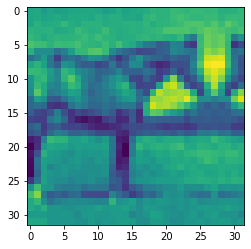

In [67]:
load_train_labeled.dataset[0][0]

import matplotlib.pyplot as plt
plt.imshow(load_train_labeled.dataset[100][0].detach().cpu().numpy()[0])

11-04 18:19:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


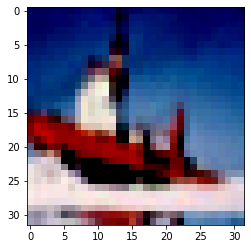

In [83]:
idx = 48
x_p = x_p_d[idx:idx+1]
args.num_diffusion_timesteps = 100
diffusion = RecoveryLikelihood(args)
tttt = []
for i in range(args.num_diffusion_timesteps):
    tttt.append(x_p.clone())
x_p = torch.cat(tttt)

t = np.random.randint(low=0, high=diffusion.num_timesteps)
# t = torch.LongTensor(np.arange(7))
t = torch.arange(0, diffusion.num_timesteps, dtype=torch.long) # randint(size=[x_p.shape[0]], high=6, device=device)
k = diffusion.q_sample_pairs(x_p, t)
print(t)

import matplotlib.pyplot as plt
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[0])

In [84]:
k[0].shape

torch.Size([100, 3, 32, 32])

11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:29: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-04 18:27:2

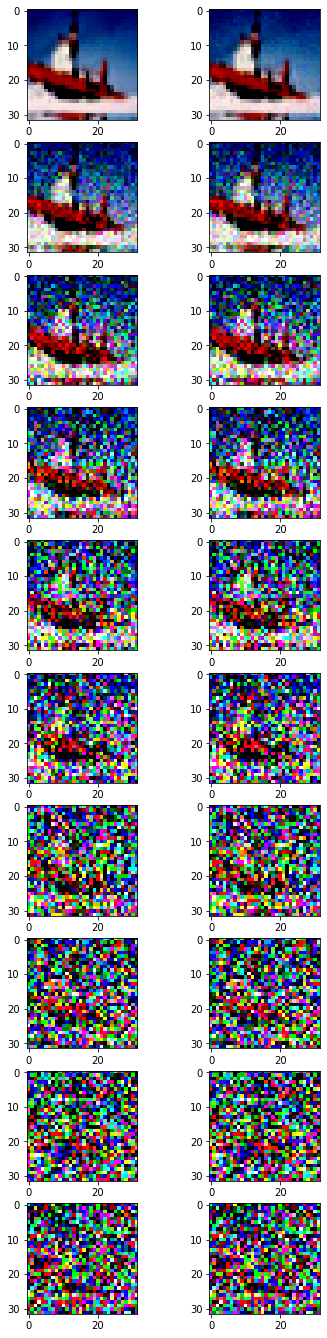

In [91]:

fig, axs = plt.subplots(10, 2, figsize=(6, 24))

for i in range(10):
    for j in range(2):
        axs[i, j].imshow(k[j][i * 10].permute(1, 2, 0))

11-04 17:27:48: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


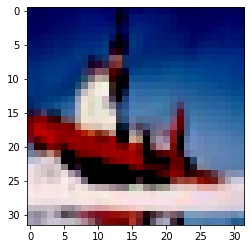

In [70]:
idx = 48
a = x_p_d.permute((0, 2, 3, 1)).detach().cpu().numpy()[idx]
plt.imshow(a)

11-04 18:21:49: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


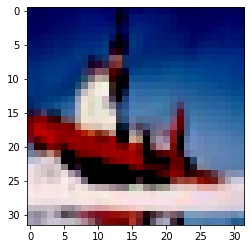

In [85]:
b = np.load('aship.npy')
plt.imshow(b)

11-02 11:25:55: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


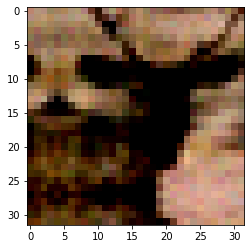

11-02 11:25:55: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


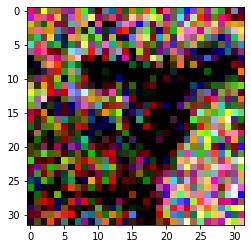

11-02 11:25:56: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


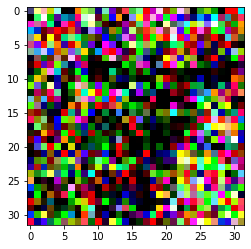

11-02 11:25:56: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


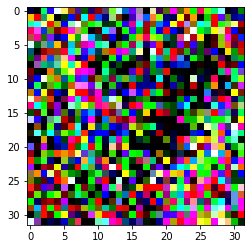

11-02 11:25:56: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


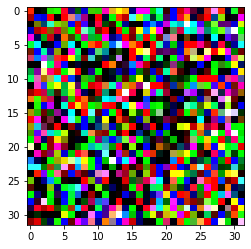

11-02 11:25:56: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


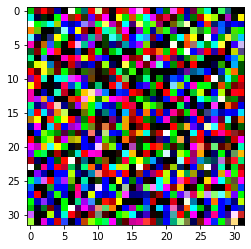

In [27]:
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[0])
plt.show()
plt.close()
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[1])
plt.show()
plt.close()
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[2])
plt.show()
plt.close()
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[3])
plt.show()
plt.close()
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[4])
plt.show()
plt.close()
plt.imshow(k[0].permute((0, 2, 3, 1)).detach().cpu().numpy()[5])
plt.show()
plt.close()


11-02 12:27:11: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


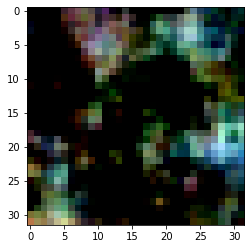

In [47]:

noise = dist.sample((1, )).view((1, 3, 32, 32)) # .permute((0, 2, 3, 1))
plt.imshow(noise[0].cpu().numpy())

In [43]:
sigmas, a_s = get_sigma_schedule(beta_start=0.0001, beta_end=0.02, num_diffusion_timesteps=6)
sigmas = torch.FloatTensor(sigmas).to(args.device)
a_s = torch.FloatTensor(a_s).to(args.device)
a_s_cum = torch.FloatTensor(np.cumprod(a_s)).to(args.device)
sigmas_cum = torch.sqrt(1 - a_s_cum ** 2)

11-02 12:27:43: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11-02 12:27:43: image.py[722]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


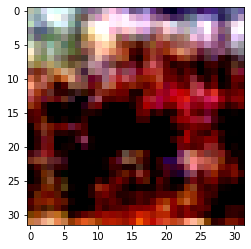

In [49]:
def extract(a, t, x_shape, device):
    """
    Extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    if isinstance(t, int) or len(t.shape) == 0:
        t = torch.ones(x_shape[0], dtype=torch.int64, device=device) * t
    bs, = t.shape
    assert x_shape[0] == bs
    out = a[t]
    # out = tf.gather(tf.convert_to_tensor(a, dtype=tf.float32), t)
    # print(out.shape, t.shape, bs)
    assert list(out.shape) == [bs]
    return torch.reshape(out, [bs] + ((len(x_shape) - 1) * [1]))

# x_t = self._extract(self.a_s_cum, t, x_start.shape, self.args.device) * x_start +
#       self._extract(self.sigmas_cum, t, x_start.shape, self.args.device) * noise
t = 5
x_t = extract(a_s_cum, t, x_p.shape, args.device) * x_p

plt.imshow(x_t.permute((0, 2, 3, 1)).detach().cpu().numpy()[0])

noise = dist.sample((1, )).view((1, 3, 32, 32)) # .permute((0, 2, 3, 1))
x_t += extract(sigmas_cum, t, x_p.shape, args.device) * noise

plt.imshow(x_t.permute((0, 2, 3, 1)).detach().cpu().numpy()[0])

In [ ]:
plt.imshow(noise.permute((0, 2, 3, 1)).detach().cpu().numpy()[0])